# 셋팅 & 라이브러리

https://github.com/minsuk-sung/intel-image-classification/blob/master/Lecture06%20-%20CIFAR100.ipynb

In [1]:
import wandb
import tensorflow as tf
import numpy as np
# import cv2
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar100
from keras import models, layers

from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Lambda

from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import categorical_crossentropy,binary_crossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.utils import get_custom_objects

In [3]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, ElementTree

# Wandb

In [4]:
wandb.login()

wandb: Currently logged in as: phd1150 (diplab). Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project='DualPooing_Mac', name='MinPooing')

In [6]:
wandb.config = {
    "learning_rate": 0.001,
    "epoch": 60,
    "batch_size": 32
}

In [9]:
'''
wandb.log({"loss": 0.314, "epoch": 50,
           "inputs": wandb.Image(inputs),
           "logits": wandb.Histogram(ouputs),
           "captions": wandb.Html(captions)})
'''

'\nwandb.log({"loss": 0.314, "epoch": 50,\n           "inputs": wandb.Image(inputs),\n           "logits": wandb.Histogram(ouputs),\n           "captions": wandb.Html(captions)})\n'

# 데이터 준비

In [7]:
(X_train, y_train), (X_test,y_test) = cifar100.load_data()

In [8]:
CIFAR100_CLASSES = sorted(['beaver', 'dolphin', 'otter', 'seal', 'whale',  # aquatic mammals
                           'aquarium' 'fish', 'flatfish', 'ray', 'shark', 'trout',  # fish
                           'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', # flowers
                           'bottles', 'bowls', 'cans', 'cups', 'plates', # food containers
                           'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', # fruit and vegetables
                           'clock', 'computer' 'keyboard', 'lamp', 'telephone', 'television', # household electrical devices
                           'bed', 'chair', 'couch', 'table', 'wardrobe', # household furniture
                           'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', # insects
                           'bear', 'leopard', 'lion', 'tiger', 'wolf', # large carnivores
                           'bridge', 'castle', 'house', 'road', 'skyscraper', # large man-made outdoor things
                           'cloud', 'forest', 'mountain', 'plain', 'sea', # large natural outdoor scenes
                           'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', # large omnivores and herbivores
                           'fox', 'porcupine', 'possum', 'raccoon', 'skunk', # medium-sized mammals
                           'crab', 'lobster', 'snail', 'spider', 'worm', # non-insect invertebrates
                           'baby', 'boy', 'girl', 'man', 'woman', # people
                           'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', # reptiles
                           'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', # small mammals
                           'maple', 'oak', 'palm', 'pine', 'willow', # trees
                           'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', # vehicles 1
                           'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor' # vehicles 2
                          ])
print('클래스 길이: ',len(CIFAR100_CLASSES))

클래스 길이:  100


In [9]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2,shuffle=True,random_state=0)

In [10]:
print('CIFAR-100 Train 데이터의 크기 : {}'.format(len(X_train)))
print('CIFAR-100 Validation 데이터의 크기 : {}'.format(len(X_valid)))
print('CIFAR-100 Test 데이터의 크기 : {}'.format(len(X_test)))

CIFAR-100 Train 데이터의 크기 : 40000
CIFAR-100 Validation 데이터의 크기 : 10000
CIFAR-100 Test 데이터의 크기 : 10000


In [11]:
print("X_train Shape : ",X_train.shape) # 32*32짜리 크기의 RGB 이미지 40000개
print("y_train Shape : ",y_train.shape) # 각 이미지별 레이블 40000개

X_train Shape :  (40000, 32, 32, 3)
y_train Shape :  (40000, 1)


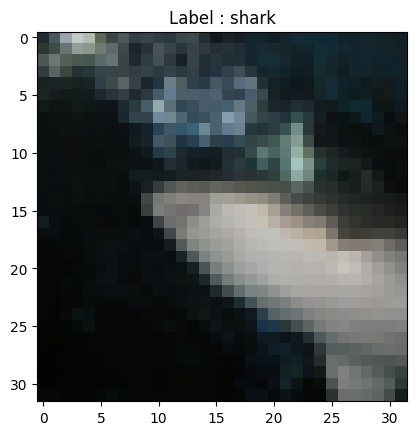

In [12]:
idx = 0

plt.imshow(X_train[idx], interpolation='nearest')
plt.title('Label : {}'.format(CIFAR100_CLASSES[y_train[idx][0]]))
plt.show()

In [13]:
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0],32,32,3)
print(X_train.shape)

(40000, 32, 32, 3)
(40000, 32, 32, 3)


In [14]:
X_train[0].shape

(32, 32, 3)

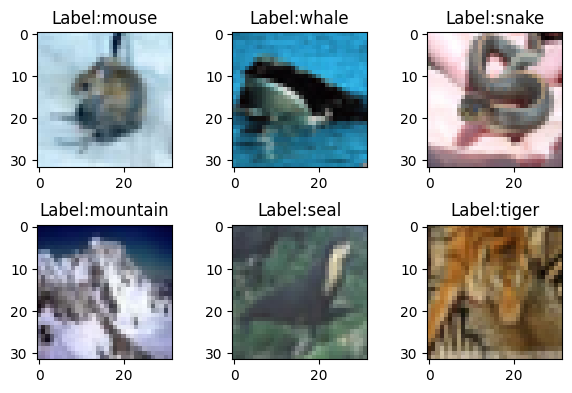

In [15]:
# 재연성을 위하여 랜덤시드 고정
np.random.seed(1234) 

# random 함수를 통해서 임의의 16개 데이터 가져오기
samples = np.random.randint(0,len(X_train)+1,size=6)

# MNIST를 그릴 Figure 준비
plt.figure(figsize=(6,4))

# 16개의 이미지 시각화
for count, n in enumerate(samples,start=1):
    plt.subplot(2, 3, count)
    plt.imshow(X_train[n], interpolation='nearest')
    label_name = "Label:" + str(CIFAR100_CLASSES[y_train[n][0]])
    plt.title(label_name)

plt.tight_layout()
plt.show()

In [16]:
# 데이터 크기 조정(Data Reshape)
X_train = X_train.reshape(X_train.shape[0],32,32,3)
X_valid = X_valid.reshape(X_valid.shape[0],32,32,3)
X_test = X_test.reshape(X_test.shape[0],32,32,3)

# 데이터 포맷 바꾸기
# 정수(int)인 데이터에서 실수(float)으로 변환
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# 데이터 정규화(Data Regularization)
# 이 과정을 통해서 추후 학습할 신경망이 조금 더 학습이 원할히 될 수 있게함
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

# 원-핫 인코딩(One Hot Encoding)
# Keras의 to_categorical함수를 통해서 모든 Train 데이터의 레이블을 벡터화(Vectorize)
# ex) [3] -> [0 0 0 1 0 0 0 0 0 0]
y_train = to_categorical(y_train, 100) 
y_valid = to_categorical(y_valid,100)
y_test = to_categorical(y_test, 100)

# Custom Layers

In [112]:
def min_pool(x):
    print('x_shape: ',x.shape)
    n_channel = x.shape[-1]
    
    patches = tf.image.extract_patches(x,
                                       sizes = [1, 2, 2, 1], 
                                       strides = [1, 2, 2, 1], 
                                       rates = 4*[1],
                                       padding = 'SAME')
    
    channel_pool = [tf.reduce_min(patches[:,:,:,c::n_channel], keepdims=True, axis=-1) for c in range(n_channel)]
    
    return tf.concat(channel_pool, axis=-1)

In [ ]:
def min_pool_2(x):
    # print('x_shape: ',x.shape)
    n_channel = x.shape[-1]
    
    B = x.shape[0]
    w = x.shape[1]
    h = x.shape[2]
    # print('B, w, h, C: ',B,w,h,n_channel)
    
    
    patches = tf.image.extract_patches(x,
                                       sizes = [1, 2, 2, 1], 
                                       strides = [1, 2, 2, 1], 
                                       rates = 4*[1],
                                       padding = 'SAME')
    
    patches = tf.reshape(patches, shape = (-1, w//2, h//2, 2, 2, n_channel))

    pooling = tf.reduce_min(patches, axis = [-3,-2])

    return pooling

In [18]:
class MinPooling(tf.keras.layers.Layer):
    def __init__(self):
        super(MinPooling, self).__init__()

    def call(self, x):
        result = min_pool_2(x)
        
        return result        

In [19]:
class Inv_Relu(Activation):
    def __init__(self, activation, **kwargs):
        super(Inv_Relu, self).__init__(activation, **kwargs)
        self.__name__ = 'inv_Relu'

def inv_Relu(x):    
    return tf.math.minimum(x, 0)

get_custom_objects().update({'inv_Relu': Inv_Relu(inv_Relu)})

# 모델

### MaxPooling

In [78]:
def build_vgg_block(input_layer,
                    num_cnn=3, # conv 필터 개수 (여기선 2 or 3)
                    channel=64,
                    block_num=1,
                   ):
    
    # 입력 레이어
    x = input_layer # type(x) : <class 'keras.engine.keras_tensor.KerasTensor'>
    
    # CNN 레이어
    for cnn_layer in range(num_cnn):        
        x = layers.Conv2D(filters=channel,
                          kernel_size=(3,3),
                          activation=None,
                          # kernel_initializer='he_normal',
                          padding='same',
                          name=f'Max_block{block_num}_conv{cnn_layer}'
                         )(x)
        x = BatchNormalization()(x)
        x = tf.nn.relu(x)
    # Max Pooling 레이어
    x = layers.MaxPooling2D(pool_size=(2,2),
                            strides=2,
                            name=f'Max_block{block_num}_pooling'
                           )(x)
    
    #x = BatchNormalization()(x)
    
    return x        

def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3],
              channel_list=[64,128,256,512],
              num_classes=100):
    
    assert len(num_cnn_list) == len(channel_list), '길이가 다르다' # 블럭의 개수가 됨. 둘이 같은지 점검하는 코드
    
    input_layer = Input(shape=input_shape) # input layer 생성
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(output,
                                 num_cnn=num_cnn,
                                 channel=channel,
                                 block_num=i
                                )
    
    output = layers.Flatten(name='Max_flatten')(output)
    # output = BatchNormalization()(output)
    output = layers.Dense(512, activation=None,name='Max_fc1')(output)
    output = BatchNormalization()(output)
    output = tf.nn.relu(output)
    output = layers.Dense(512, activation=None,name='Max_fc2')(output)
    output = BatchNormalization()(output)
    output = tf.nn.relu(output)
    output = layers.Dense(num_classes, activation='softmax',name='Max_predictions')(output)
    
    model = Model(inputs=input_layer,
                        outputs=output)
    
    return model

In [32]:
vgg_16 = build_vgg()
vgg_16.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 Max_block0_conv0 (Conv2D)   (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_46 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 tf.nn.relu_22 (TFOpLambda)  (None, 32, 32, 64)        0         
                                                                 
 Max_block0_conv1 (Conv2D)   (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_47 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

### MinPooling

In [20]:
def M_build_vgg_block(input_layer,
                    num_cnn=3, # conv 필터 개수 (여기선 2 or 3)
                    channel=64,
                    block_num=1,
                   ):
    
    # 입력 레이어
    x = input_layer # type(x) : <class 'keras.engine.keras_tensor.KerasTensor'>
    
    # CNN 레이어
    for cnn_layer in range(num_cnn):        
        x = layers.Conv2D(filters=channel,
                          kernel_size=(3,3),
                          activation=None,
                          # kernel_initializer='he_normal',
                          padding='same',
                          name=f'Min_block{block_num}_conv{cnn_layer}'
                         )(x)
        x = BatchNormalization()(x)
        x = Activation('inv_Relu')(x)
    # 변경점
    # Min Pooling 레이어
    x = MinPooling()(x) # 클래스 선언 + call ?
    
    # x = BatchNormalization()(x)
    
    return x

def M_build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3],
              channel_list=[64,128,256,512],
              num_classes=100):
    
    assert len(num_cnn_list) == len(channel_list), '길이가 다르다' # 블럭의 개수가 됨. 둘이 같은지 점검하는 코드
    
    input_layer = Input(shape=input_shape) # input layer 생성
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = M_build_vgg_block(output,
                                 num_cnn=num_cnn,
                                 channel=channel,
                                 block_num=i
                                )
    
    output = layers.Flatten(name='Min_flatten')(output)
    # x = BatchNormalization()(x)
    output = layers.Dense(512, activation=None,name='Min_fc1')(output)
    output = BatchNormalization()(output)
    output = Activation('inv_Relu')(output)
    output = layers.Dense(512, activation=None,name='Min_fc2')(output)
    output = BatchNormalization()(output)
    output = Activation('inv_Relu')(output)
    output = layers.Dense(num_classes, activation='softmax',name='Min_predictions')(output)
    
    model = Model(inputs=input_layer,
                        outputs=output)
    
    return model

In [21]:
M_vgg_16 = M_build_vgg()
M_vgg_16.summary()

2022-10-13 12:37:12.565171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-13 12:37:12.565278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 Min_block0_conv0 (Conv2D)   (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 Mi

### Dual Pooling

In [35]:
# Type 1 (Add)
def D_build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3],
              channel_list=[64,128,256,512],
              num_classes=100):
    
    assert len(num_cnn_list) == len(channel_list), '길이가 다르다' # 블럭의 개수가 됨. 둘이 같은지 점검하는 코드
    
    input_layer = Input(shape=input_shape) # input layer 생성
    output1 = input_layer
    output2 = input_layer
    
    # Max
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output1 = build_vgg_block(output1,
                                 num_cnn=num_cnn,
                                 channel=channel,
                                 block_num=i
                                )
    
    output1 = layers.Flatten(name='Max_flatten')(output1)
    output1 = layers.Dense(512, activation='relu',name='Max_fc1')(output1)
    output1 = layers.Dense(512, activation='relu',name='Max_fc2')(output1)
    # output1 = layers.Dense(num_classes, activation='softmax',name='Max_predictions')(output1)
    
    # Min
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output2 = M_build_vgg_block(output2,
                                 num_cnn=num_cnn,
                                 channel=channel,
                                 block_num=i
                                )
    
    output2 = layers.Flatten(name='Min_flatten')(output2)
    output2 = layers.Dense(512, activation='relu',name='Min_fc1')(output2)
    output2 = layers.Dense(512, activation='relu',name='Min_fc2')(output2)
    # output2 = layers.Dense(num_classes, activation='softmax',name='Min_predictions')(output2)
    
    # 결합부
    # 1
    # output = Add()([output1, output2])
    # 2
    output = tf.concat([output1, output2], 1)
    
    output = layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    model = Model(inputs=input_layer,
                        outputs=output)
    
    return model

In [27]:
D_vgg_16 = D_build_vgg()
D_vgg_16.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Max_block0_conv0 (Conv2D)      (None, 32, 32, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 Min_block0_conv0 (Conv2D)      (None, 32, 32, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 Max_block0_conv1 (Conv2D)      (None, 32, 32, 64)   36928       ['Max_block0_conv0[0][0]']       
                                                                                            

In [36]:
# Type 2 (Concat)
def D2_build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3],
              channel_list=[64,128,256,512],
              num_classes=100):
    
    assert len(num_cnn_list) == len(channel_list), '길이가 다르다' # 블럭의 개수가 됨. 둘이 같은지 점검하는 코드
    
    input_layer = Input(shape=input_shape) # input layer 생성
    output1 = input_layer
    output2 = input_layer
    
    # Max
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output1 = build_vgg_block(output1,
                                 num_cnn=num_cnn,
                                 channel=channel,
                                 block_num=i
                                )
    
    # Min
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output2 = M_build_vgg_block(output2,
                                 num_cnn=num_cnn,
                                 channel=channel,
                                 block_num=i
                                )
    
    # 결합부    
    output = tf.concat([output1, output2], -1)
    output = layers.Flatten(name='Dual_flatten')(output)
    output = layers.Dense(512, activation=None,name='Dual_fc1')(output)
    output = BatchNormalization()(output)
    output = Activation('inv_Relu')(output)
    output = layers.Dense(512, activation=None,name='Dual_fc2')(output)    
    output = BatchNormalization()(output)
    output = Activation('inv_Relu')(output)
    output = layers.Dense(num_classes, activation='softmax',name='predictions')(output)
    model = Model(inputs=input_layer,
                        outputs=output)
    
    return model

In [37]:
D2_vgg_16 = D2_build_vgg()
D2_vgg_16.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Max_block0_conv0 (Conv2D)      (None, 32, 32, 64)   1792        ['input_6[0][0]']                
                                                                                                  
 Min_block0_conv0 (Conv2D)      (None, 32, 32, 64)   1792        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_70 (BatchN  (None, 32, 32, 64)  256         ['Max_block0_conv0[0][0]']       
 ormalization)                                                                              

# 모델 학습

In [22]:
EPOCHS = 60
BATCH_SIZE = 16

In [23]:
wandbcallback_M=wandb.keras.WandbCallback("val_acc", mode="max")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [39]:
# Max
vgg_16.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['acc','top_k_categorical_accuracy'])

history = vgg_16.fit(X_train,  # 학습할 데이터
                    y_train,  # 학습할 레이블
                    epochs=EPOCHS,  # 전체 학습할 횟수
                    batch_size=BATCH_SIZE,  # 배치 사이즈
                    use_multiprocessing=True,
                    validation_data=(X_valid, y_valid), # 검증 데이터로 확인
                    callbacks=[wandbcallback_M]
                   )

Epoch 1/60


2022-10-12 13:27:33.022836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2499/2500 [============================>.] - ETA: 0s - loss: 4.2021 - acc: 0.0598 - top_k_categorical_accuracy: 0.2129

2022-10-12 13:28:44.341307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.3s


2500/2500 [==============================] - 81s 32ms/step - loss: 4.2020 - acc: 0.0598 - top_k_categorical_accuracy: 0.2130 - val_loss: 3.8161 - val_acc: 0.1019 - val_top_k_categorical_accuracy: 0.3241
Epoch 2/60
2500/2500 [==============================] - ETA: 0s - loss: 3.6546 - acc: 0.1313 - top_k_categorical_accuracy: 0.3773

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 81s 33ms/step - loss: 3.6546 - acc: 0.1313 - top_k_categorical_accuracy: 0.3773 - val_loss: 3.3656 - val_acc: 0.1861 - val_top_k_categorical_accuracy: 0.4669
Epoch 3/60
2500/2500 [==============================] - ETA: 0s - loss: 3.1739 - acc: 0.2124 - top_k_categorical_accuracy: 0.5076

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 3.1739 - acc: 0.2124 - top_k_categorical_accuracy: 0.5076 - val_loss: 2.9087 - val_acc: 0.2635 - val_top_k_categorical_accuracy: 0.5720
Epoch 4/60
2499/2500 [============================>.] - ETA: 0s - loss: 2.7785 - acc: 0.2874 - top_k_categorical_accuracy: 0.6063

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 79s 32ms/step - loss: 2.7787 - acc: 0.2873 - top_k_categorical_accuracy: 0.6063 - val_loss: 2.6906 - val_acc: 0.3055 - val_top_k_categorical_accuracy: 0.6337
Epoch 5/60
2499/2500 [============================>.] - ETA: 0s - loss: 2.4600 - acc: 0.3467 - top_k_categorical_accuracy: 0.6807

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 2.4601 - acc: 0.3467 - top_k_categorical_accuracy: 0.6807 - val_loss: 2.4205 - val_acc: 0.3576 - val_top_k_categorical_accuracy: 0.6863
Epoch 6/60
2499/2500 [============================>.] - ETA: 0s - loss: 2.2096 - acc: 0.4020 - top_k_categorical_accuracy: 0.7332

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 2.2094 - acc: 0.4020 - top_k_categorical_accuracy: 0.7333 - val_loss: 2.5301 - val_acc: 0.3586 - val_top_k_categorical_accuracy: 0.6862
Epoch 7/60
2499/2500 [============================>.] - ETA: 0s - loss: 2.0061 - acc: 0.4493 - top_k_categorical_accuracy: 0.7762

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 2.0063 - acc: 0.4493 - top_k_categorical_accuracy: 0.7762 - val_loss: 2.2898 - val_acc: 0.4054 - val_top_k_categorical_accuracy: 0.7289
Epoch 8/60
2499/2500 [============================>.] - ETA: 0s - loss: 1.8200 - acc: 0.4891 - top_k_categorical_accuracy: 0.8082

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 79s 32ms/step - loss: 1.8199 - acc: 0.4891 - top_k_categorical_accuracy: 0.8082 - val_loss: 2.1711 - val_acc: 0.4372 - val_top_k_categorical_accuracy: 0.7516
Epoch 9/60
2500/2500 [==============================] - 78s 31ms/step - loss: 1.6352 - acc: 0.5329 - top_k_categorical_accuracy: 0.8402 - val_loss: 2.1987 - val_acc: 0.4357 - val_top_k_categorical_accuracy: 0.7613
Epoch 10/60
2500/2500 [==============================] - ETA: 0s - loss: 1.4548 - acc: 0.5761 - top_k_categorical_accuracy: 0.8708

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 81s 32ms/step - loss: 1.4548 - acc: 0.5761 - top_k_categorical_accuracy: 0.8708 - val_loss: 2.0944 - val_acc: 0.4609 - val_top_k_categorical_accuracy: 0.7791
Epoch 11/60
2500/2500 [==============================] - ETA: 0s - loss: 1.2975 - acc: 0.6170 - top_k_categorical_accuracy: 0.8967

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 1.2975 - acc: 0.6170 - top_k_categorical_accuracy: 0.8967 - val_loss: 2.0389 - val_acc: 0.4909 - val_top_k_categorical_accuracy: 0.7950
Epoch 12/60
2500/2500 [==============================] - 78s 31ms/step - loss: 1.1231 - acc: 0.6625 - top_k_categorical_accuracy: 0.9217 - val_loss: 2.1819 - val_acc: 0.4805 - val_top_k_categorical_accuracy: 0.7856
Epoch 13/60
2500/2500 [==============================] - 78s 31ms/step - loss: 0.9792 - acc: 0.6996 - top_k_categorical_accuracy: 0.9397 - val_loss: 2.2187 - val_acc: 0.4809 - val_top_k_categorical_accuracy: 0.7856
Epoch 14/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.8375 - acc: 0.7384 - top_k_categorical_accuracy: 0.9566 - val_loss: 2.2923 - val_acc: 0.4908 - val_top_k_categorical_accuracy: 0.7828
Epoch 15/60
2500/2500 [==============================] - ETA: 0s - loss: 0.6999 - acc: 0.7773 - top_k_categorical_accuracy: 0.9696

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 81s 32ms/step - loss: 0.6999 - acc: 0.7773 - top_k_categorical_accuracy: 0.9696 - val_loss: 2.3912 - val_acc: 0.4920 - val_top_k_categorical_accuracy: 0.7869
Epoch 16/60
2499/2500 [============================>.] - ETA: 0s - loss: 0.6097 - acc: 0.8046 - top_k_categorical_accuracy: 0.9773

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 77s 31ms/step - loss: 0.6097 - acc: 0.8046 - top_k_categorical_accuracy: 0.9774 - val_loss: 2.4866 - val_acc: 0.4934 - val_top_k_categorical_accuracy: 0.7789
Epoch 17/60
2500/2500 [==============================] - 78s 31ms/step - loss: 0.5139 - acc: 0.8343 - top_k_categorical_accuracy: 0.9853 - val_loss: 2.6494 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7814
Epoch 18/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.4496 - acc: 0.8533 - top_k_categorical_accuracy: 0.9880 - val_loss: 2.8681 - val_acc: 0.4846 - val_top_k_categorical_accuracy: 0.7780
Epoch 19/60
2499/2500 [============================>.] - ETA: 0s - loss: 0.3935 - acc: 0.8701 - top_k_categorical_accuracy: 0.9918

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 79s 32ms/step - loss: 0.3934 - acc: 0.8702 - top_k_categorical_accuracy: 0.9919 - val_loss: 2.8068 - val_acc: 0.5027 - val_top_k_categorical_accuracy: 0.7926
Epoch 20/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.3460 - acc: 0.8854 - top_k_categorical_accuracy: 0.9934 - val_loss: 3.1025 - val_acc: 0.4836 - val_top_k_categorical_accuracy: 0.7771
Epoch 21/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.3169 - acc: 0.8946 - top_k_categorical_accuracy: 0.9942 - val_loss: 3.1638 - val_acc: 0.4873 - val_top_k_categorical_accuracy: 0.7769
Epoch 22/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.2903 - acc: 0.9051 - top_k_categorical_accuracy: 0.9953 - val_loss: 3.0995 - val_acc: 0.4980 - val_top_k_categorical_accuracy: 0.7805
Epoch 23/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.2644 - acc: 0.9126 - top_k_categorical_accuracy: 0.9963 - val_loss: 3.2

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 0.1668 - acc: 0.9452 - top_k_categorical_accuracy: 0.9985 - val_loss: 3.5472 - val_acc: 0.5059 - val_top_k_categorical_accuracy: 0.7836
Epoch 31/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.1724 - acc: 0.9448 - top_k_categorical_accuracy: 0.9979 - val_loss: 3.7215 - val_acc: 0.4862 - val_top_k_categorical_accuracy: 0.7690
Epoch 32/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.1556 - acc: 0.9497 - top_k_categorical_accuracy: 0.9986 - val_loss: 3.7019 - val_acc: 0.4975 - val_top_k_categorical_accuracy: 0.7766
Epoch 33/60
2500/2500 [==============================] - 78s 31ms/step - loss: 0.1455 - acc: 0.9530 - top_k_categorical_accuracy: 0.9986 - val_loss: 3.6933 - val_acc: 0.5045 - val_top_k_categorical_accuracy: 0.7830
Epoch 34/60
2499/2500 [============================>.] - ETA: 0s - loss: 0.1500 - acc: 0.9513 - top_k_categorical_accuracy: 0.9985

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 0.1500 - acc: 0.9513 - top_k_categorical_accuracy: 0.9985 - val_loss: 3.6008 - val_acc: 0.5131 - val_top_k_categorical_accuracy: 0.7904
Epoch 35/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.1348 - acc: 0.9560 - top_k_categorical_accuracy: 0.9989 - val_loss: 3.6406 - val_acc: 0.5119 - val_top_k_categorical_accuracy: 0.7892
Epoch 36/60
2500/2500 [==============================] - 78s 31ms/step - loss: 0.1337 - acc: 0.9565 - top_k_categorical_accuracy: 0.9987 - val_loss: 3.7145 - val_acc: 0.5055 - val_top_k_categorical_accuracy: 0.7862
Epoch 37/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.1285 - acc: 0.9590 - top_k_categorical_accuracy: 0.9988 - val_loss: 3.8037 - val_acc: 0.5005 - val_top_k_categorical_accuracy: 0.7827
Epoch 38/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.1299 - acc: 0.9581 - top_k_categorical_accuracy: 0.9989 - val_loss: 3.8

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221012_132512-3v9e9kz2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 80s 32ms/step - loss: 0.0746 - acc: 0.9759 - top_k_categorical_accuracy: 0.9995 - val_loss: 3.9978 - val_acc: 0.5153 - val_top_k_categorical_accuracy: 0.7748
Epoch 59/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.0708 - acc: 0.9781 - top_k_categorical_accuracy: 0.9994 - val_loss: 4.0581 - val_acc: 0.5109 - val_top_k_categorical_accuracy: 0.7764
Epoch 60/60
2500/2500 [==============================] - 77s 31ms/step - loss: 0.0712 - acc: 0.9769 - top_k_categorical_accuracy: 0.9997 - val_loss: 4.2068 - val_acc: 0.5057 - val_top_k_categorical_accuracy: 0.7673


In [ ]:
# Min
M_vgg_16.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['acc','top_k_categorical_accuracy'])

history = M_vgg_16.fit(X_train,  # 학습할 데이터
                    y_train,  # 학습할 레이블
                    epochs=EPOCHS,  # 전체 학습할 횟수
                    batch_size=BATCH_SIZE,  # 배치 사이즈
                    use_multiprocessing=True,
                    validation_data=(X_valid, y_valid), # 검증 데이터로 확인
                    callbacks=[wandbcallback_M]
                   )

Epoch 1/60


2022-10-13 12:37:49.311430: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


x_shape:  (16, 32, 32, 64)
B, w, h, C:  16 32 32 64
x_shape:  (16, 16, 16, 128)
B, w, h, C:  16 16 16 128
x_shape:  (16, 8, 8, 256)
B, w, h, C:  16 8 8 256
x_shape:  (16, 4, 4, 512)
B, w, h, C:  16 4 4 512
x_shape:  (16, 32, 32, 64)
B, w, h, C:  16 32 32 64
x_shape:  (16, 16, 16, 128)
B, w, h, C:  16 16 16 128
x_shape:  (16, 8, 8, 256)
B, w, h, C:  16 8 8 256
x_shape:  (16, 4, 4, 512)
B, w, h, C:  16 4 4 512


2022-10-13 12:37:49.981052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - ETA: 0s - loss: 4.1820 - acc: 0.0646 - top_k_categorical_accuracy: 0.2260x_shape:  (16, 32, 32, 64)
B, w, h, C:  16 32 32 64
x_shape:  (16, 16, 16, 128)
B, w, h, C:  16 16 16 128
x_shape:  (16, 8, 8, 256)
B, w, h, C:  16 8 8 256
x_shape:  (16, 4, 4, 512)
B, w, h, C:  16 4 4 512


2022-10-13 12:40:14.773915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 12

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.3s


2500/2500 [==============================] - 161s 64ms/step - loss: 4.1820 - acc: 0.0646 - top_k_categorical_accuracy: 0.2260 - val_loss: 7.2977 - val_acc: 0.0299 - val_top_k_categorical_accuracy: 0.1260
Epoch 2/60
2500/2500 [==============================] - ETA: 0s - loss: 3.5494 - acc: 0.1525 - top_k_categorical_accuracy: 0.4083x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 211s 85ms/step - loss: 3.5494 - acc: 0.1525 - top_k_categorical_accuracy: 0.4083 - val_loss: 3.7783 - val_acc: 0.1681 - val_top_k_categorical_accuracy: 0.4382
Epoch 3/60
2500/2500 [==============================] - ETA: 0s - loss: 3.0552 - acc: 0.2311 - top_k_categorical_accuracy: 0.5342x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 159s 64ms/step - loss: 3.0552 - acc: 0.2311 - top_k_categorical_accuracy: 0.5342 - val_loss: 3.2112 - val_acc: 0.2332 - val_top_k_categorical_accuracy: 0.5201
Epoch 4/60
2500/2500 [==============================] - ETA: 0s - loss: 2.6623 - acc: 0.3082 - top_k_categorical_accuracy: 0.6356x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 1100s 440ms/step - loss: 2.6623 - acc: 0.3082 - top_k_categorical_accuracy: 0.6356 - val_loss: 2.7137 - val_acc: 0.3000 - val_top_k_categorical_accuracy: 0.6293
Epoch 5/60
2500/2500 [==============================] - ETA: 0s - loss: 2.3767 - acc: 0.3659 - top_k_categorical_accuracy: 0.6984x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 163s 65ms/step - loss: 2.3767 - acc: 0.3659 - top_k_categorical_accuracy: 0.6984 - val_loss: 2.4560 - val_acc: 0.3617 - val_top_k_categorical_accuracy: 0.6849
Epoch 6/60
2500/2500 [==============================] - 212s 85ms/step - loss: 2.1431 - acc: 0.4157 - top_k_categorical_accuracy: 0.7483 - val_loss: 2.6073 - val_acc: 0.3433 - val_top_k_categorical_accuracy: 0.6540
Epoch 7/60
2500/2500 [==============================] - ETA: 0s - loss: 1.9308 - acc: 0.4641 - top_k_categorical_accuracy: 0.7876x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 1196s 478ms/step - loss: 1.9308 - acc: 0.4641 - top_k_categorical_accuracy: 0.7876 - val_loss: 2.3407 - val_acc: 0.3924 - val_top_k_categorical_accuracy: 0.7253
Epoch 8/60
2500/2500 [==============================] - ETA: 0s - loss: 1.7452 - acc: 0.5075 - top_k_categorical_accuracy: 0.8206x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 160s 64ms/step - loss: 1.7452 - acc: 0.5075 - top_k_categorical_accuracy: 0.8206 - val_loss: 2.1018 - val_acc: 0.4443 - val_top_k_categorical_accuracy: 0.7577
Epoch 9/60
2500/2500 [==============================] - ETA: 0s - loss: 1.5527 - acc: 0.5532 - top_k_categorical_accuracy: 0.8584x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 160s 64ms/step - loss: 1.5527 - acc: 0.5532 - top_k_categorical_accuracy: 0.8584 - val_loss: 2.1200 - val_acc: 0.4569 - val_top_k_categorical_accuracy: 0.7725
Epoch 10/60
2500/2500 [==============================] - ETA: 0s - loss: 1.3843 - acc: 0.5951 - top_k_categorical_accuracy: 0.8837x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512


x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 168s 67ms/step - loss: 1.3843 - acc: 0.5951 - top_k_categorical_accuracy: 0.8837 - val_loss: 2.0975 - val_acc: 0.4679 - val_top_k_categorical_accuracy: 0.7751
Epoch 11/60
2500/2500 [==============================] - ETA: 0s - loss: 1.2091 - acc: 0.6401 - top_k_categorical_accuracy: 0.9095x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512


x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 2040s 816ms/step - loss: 1.2091 - acc: 0.6401 - top_k_categorical_accuracy: 0.9095 - val_loss: 2.0956 - val_acc: 0.4759 - val_top_k_categorical_accuracy: 0.7872
Epoch 12/60
2500/2500 [==============================] - ETA: 0s - loss: 1.0545 - acc: 0.6779 - top_k_categorical_accuracy: 0.9299x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
x_shape:  (None, 32, 32, 64)
B, w, h, C:  None 32 32 64
x_shape:  (None, 16, 16, 128)
B, w, h, C:  None 16 16 128
x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 51

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 161s 64ms/step - loss: 1.0545 - acc: 0.6779 - top_k_categorical_accuracy: 0.9299 - val_loss: 2.1387 - val_acc: 0.4909 - val_top_k_categorical_accuracy: 0.7878
Epoch 13/60
2500/2500 [==============================] - 158s 63ms/step - loss: 0.9016 - acc: 0.7233 - top_k_categorical_accuracy: 0.9488 - val_loss: 2.4607 - val_acc: 0.4637 - val_top_k_categorical_accuracy: 0.7678
Epoch 14/60
2500/2500 [==============================] - 158s 63ms/step - loss: 0.7582 - acc: 0.7612 - top_k_categorical_accuracy: 0.9646 - val_loss: 2.4556 - val_acc: 0.4672 - val_top_k_categorical_accuracy: 0.7713
Epoch 15/60
2500/2500 [==============================] - 166s 66ms/step - loss: 0.6407 - acc: 0.7960 - top_k_categorical_accuracy: 0.9750 - val_loss: 2.4633 - val_acc: 0.4900 - val_top_k_categorical_accuracy: 0.7806
Epoch 16/60
2500/2500 [==============================] - 169s 68ms/step - loss: 0.5437 - acc: 0.8252 - top_k_categorical_accuracy: 0.9825 - val_loss

x_shape:  (None, 8, 8, 256)
B, w, h, C:  None 8 8 256
x_shape:  (None, 4, 4, 512)
B, w, h, C:  None 4 4 512
INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 174s 70ms/step - loss: 0.4691 - acc: 0.8453 - top_k_categorical_accuracy: 0.9874 - val_loss: 2.5893 - val_acc: 0.5006 - val_top_k_categorical_accuracy: 0.7895
Epoch 18/60
2500/2500 [==============================] - 173s 69ms/step - loss: 0.4027 - acc: 0.8704 - top_k_categorical_accuracy: 0.9909 - val_loss: 3.1126 - val_acc: 0.4753 - val_top_k_categorical_accuracy: 0.7614
Epoch 19/60
2500/2500 [==============================] - 179s 72ms/step - loss: 0.3639 - acc: 0.8786 - top_k_categorical_accuracy: 0.9931 - val_loss: 3.0044 - val_acc: 0.4940 - val_top_k_categorical_accuracy: 0.7749
Epoch 20/60
2500/2500 [==============================] - 186s 75ms/step - loss: 0.3261 - acc: 0.8935 - top_k_categorical_accuracy: 0.9940 - val_loss: 3.3836 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7597
Epoch 21/60
2500/2500 [==============================] - 188s 75ms/step - loss: 0.2958 - acc: 0.9038 - top_k_categorical_accuracy: 0.9951 - val_loss

INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best/assets
wandb: Adding directory to artifact (/Users/dip_phd/PHD/wandb/run-20221013_123617-3r4niog2/files/model-best)... Done. 0.2s


2500/2500 [==============================] - 193s 77ms/step - loss: 0.1641 - acc: 0.9462 - top_k_categorical_accuracy: 0.9985 - val_loss: 3.5740 - val_acc: 0.5022 - val_top_k_categorical_accuracy: 0.7767
Epoch 32/60
2500/2500 [==============================] - 196s 78ms/step - loss: 0.1463 - acc: 0.9525 - top_k_categorical_accuracy: 0.9985 - val_loss: 3.9945 - val_acc: 0.4867 - val_top_k_categorical_accuracy: 0.7649
Epoch 33/60
2500/2500 [==============================] - 187s 75ms/step - loss: 0.1519 - acc: 0.9507 - top_k_categorical_accuracy: 0.9987 - val_loss: 3.7737 - val_acc: 0.4843 - val_top_k_categorical_accuracy: 0.7674
Epoch 34/60
2500/2500 [==============================] - 190s 76ms/step - loss: 0.1477 - acc: 0.9521 - top_k_categorical_accuracy: 0.9986 - val_loss: 3.7237 - val_acc: 0.4957 - val_top_k_categorical_accuracy: 0.7755
Epoch 35/60
1806/2500 [====================>.........] - ETA: 48s - loss: 0.1255 - acc: 0.9599 - top_k_categorical_accuracy: 0.9987

wandb: Network error (ConnectionError), entering retry loop.


2500/2500 [==============================] - 264s 106ms/step - loss: 0.1309 - acc: 0.9579 - top_k_categorical_accuracy: 0.9988 - val_loss: 3.7205 - val_acc: 0.5015 - val_top_k_categorical_accuracy: 0.7724
Epoch 36/60
1448/2500 [================>.............] - ETA: 1:01 - loss: 0.1261 - acc: 0.9592 - top_k_categorical_accuracy: 0.9987

In [34]:
# Dual
D_vgg_16.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['acc','top_k_categorical_accuracy'])



history = D_vgg_16.fit(X_train,  # 학습할 데이터
                    y_train,  # 학습할 레이블
                    epochs=EPOCHS,  # 전체 학습할 횟수
                    batch_size=BATCH_SIZE,  # 배치 사이즈
                    use_multiprocessing=True,
                    validation_data=(X_valid, y_valid), # 검증 데이터로 확인
                    callbacks=[wandbcallback_D]
                   )

Epoch 1/60
2500/2500 [==============================] - 200s 71ms/step - loss: 4.1989 - acc: 0.0551 - top_k_categorical_accuracy: 0.2044 - val_loss: 3.9461 - val_acc: 0.0825 - val_top_k_categorical_accuracy: 0.2761 - _timestamp: 1664964363.0000 - _runtime: 234.0000
Epoch 2/60
2500/2500 [==============================] - 173s 69ms/step - loss: 3.8876 - acc: 0.0952 - top_k_categorical_accuracy: 0.2996 - val_loss: 3.9771 - val_acc: 0.0888 - val_top_k_categorical_accuracy: 0.2740 - _timestamp: 1664964535.0000 - _runtime: 406.0000
Epoch 3/60
2500/2500 [==============================] - 173s 69ms/step - loss: 3.7274 - acc: 0.1185 - top_k_categorical_accuracy: 0.3508 - val_loss: 3.7316 - val_acc: 0.1197 - val_top_k_categorical_accuracy: 0.3618 - _timestamp: 1664964708.0000 - _runtime: 579.0000
Epoch 4/60
2500/2500 [==============================] - 173s 69ms/step - loss: 3.5755 - acc: 0.1464 - top_k_categorical_accuracy: 0.3957 - val_loss: 3.6377 - val_acc: 0.1445 - val_top_k_categorical_accu

In [43]:
# Dual 2
D2_vgg_16.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['acc','top_k_categorical_accuracy'])



history_2 = D2_vgg_16.fit(X_train,  # 학습할 데이터
                    y_train,  # 학습할 레이블
                    epochs=EPOCHS,  # 전체 학습할 횟수
                    batch_size=BATCH_SIZE,  # 배치 사이즈
                    use_multiprocessing=True,
                    validation_data=(X_valid, y_valid), # 검증 데이터로 확인
                    callbacks=[wandbcallback_D]
                   )

Epoch 1/60
2500/2500 [==============================] - 200s 71ms/step - loss: 4.2150 - acc: 0.0472 - top_k_categorical_accuracy: 0.1931 - val_loss: 4.0740 - val_acc: 0.0643 - val_top_k_categorical_accuracy: 0.2382 - _timestamp: 1665023217.0000 - _runtime: 267.0000
Epoch 2/60
2500/2500 [==============================] - 173s 69ms/step - loss: 3.8942 - acc: 0.0913 - top_k_categorical_accuracy: 0.2942 - val_loss: 3.8199 - val_acc: 0.1081 - val_top_k_categorical_accuracy: 0.3193 - _timestamp: 1665023390.0000 - _runtime: 440.0000
Epoch 3/60
2500/2500 [==============================] - 172s 69ms/step - loss: 3.7063 - acc: 0.1187 - top_k_categorical_accuracy: 0.3538 - val_loss: 3.6204 - val_acc: 0.1416 - val_top_k_categorical_accuracy: 0.3782 - _timestamp: 1665023562.0000 - _runtime: 612.0000
Epoch 4/60
2500/2500 [==============================] - 173s 69ms/step - loss: 3.5462 - acc: 0.1457 - top_k_categorical_accuracy: 0.3997 - val_loss: 3.4955 - val_acc: 0.1483 - val_top_k_categorical_accu

In [47]:
wandb.finish()

acc,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
top_k_categorical_accuracy,▁▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████████████████████
val_acc,▁▂▃▃▄▅▅▅▆▆▇▇▇█▇█████████████████████████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▄▄█▁▁▇
val_top_k_categorical_accuracy,▁▂▄▄▅▅▅▆▇▇▇█▇███████████████████████████
acc,0.92577
best_epoch,37
best_val_acc,0.4011
epoch,59


# 평가

In [44]:
vgg_16.evaluate(X_test, y_test, batch_size = 16)

625/625 [==============================] - 2s 4ms/step - loss: 5.4289 - acc: 0.4285 - top_k_categorical_accuracy: 0.7055


[5.42888069152832, 0.4284999966621399, 0.7055000066757202]

In [45]:
D_vgg_16.evaluate(X_test, y_test, batch_size = 16)

625/625 [==============================] - 12s 18ms/step - loss: 7.7066 - acc: 0.3414 - top_k_categorical_accuracy: 0.6294


[7.706627368927002, 0.34139999747276306, 0.6294000148773193]

In [46]:
D2_vgg_16.evaluate(X_test, y_test, batch_size = 16)

625/625 [==============================] - 11s 18ms/step - loss: 399.3070 - acc: 0.4048 - top_k_categorical_accuracy: 0.6913


[399.3070373535156, 0.4047999978065491, 0.6912999749183655]

# 메모

* Inductive bias를 비교하기위해 Test data를 써보면 어떨까

# 창고